# 基于朴素贝叶斯模型的医学短文本分类

## 目录
* [准备数据](#准备数据)
   * [载入训练数据](#载入训练数据)
   * [载入测试数据](#载入训练数据)
* [特征构建](#特征构建)
   * [基于TF-IDF算法将文本转换为向量表示](#基于TF-IDF算法将文本转换为向量表示)
   * [将类别转换为数字表示](#将类别转换为数字表示)
* [模型训练](#模型训练)
   * [模型训练](#模型训练)
   * [模型预测](#模型预测)
   * [模型保存](#模型保存)
* [模型评估](#模型评估)
   * [测试集预测](#测试集预测)
   * [混淆矩阵](#混淆矩阵)
   * [准确率、召回率、F1值](#准确率、召回率、F1值)

导入依赖包

In [2]:
import time #时间
import jieba # 中文分词
import codecs # 读取包含中文字符的文件
import pickle # 特征，模型文件保存和读取
import evaluation # 模型评估，我们自己的包

import matplotlib # 画图
import numpy as np # 数组和矩阵运算
import pandas as pd # 数据处理
import seaborn as sns # 画图
import matplotlib.pyplot as plt # 画图
from wordcloud import WordCloud # 词云显示

from sklearn.metrics import confusion_matrix # 评估指标：混淆矩阵
from sklearn.naive_bayes import MultinomialNB # 贝叶斯模型
from sklearn.model_selection import GridSearchCV # 网格搜索交叉验证调参
from sklearn.feature_extraction.text import CountVectorizer # 将文本中的词语转换为词频矩阵
from sklearn.feature_extraction.text import TfidfTransformer # 用于计算每个词语的TF-IDF值

%matplotlib inline

## 准备数据

### 载入训练数据

从文件读取

In [3]:
train_file = "../../data/train.txt" 
train_data = pd.read_csv(train_file, sep="\t", header=None, names=["id", "category", "sentence"])

In [4]:
print("训练集数据有：{}条".format(len(train_data)))
print("前5条数据为：")
train_data.head(5)

训练集数据有：8000条
前5条数据为：


,id,category,sentence
0,s1,Diagnostic,(2)若伴便秘者符合罗马Ⅳ功能性便秘诊断标准，若伴夜尿症者符合夜尿症的诊断标准；
1,s2,Therapy or Surgery,（1）患者拟行急症手术；
2,s3,Enrollment in other studies,c) 在过去6个月内参加过I、II期临床试验或者3个月内参加过III、IV期临床试验；
3,s4,Risk Assessment,4. 身高體重指數(BMI)&gt;=25得病人
4,s5,Consent,5.愿意参与该研究并配合调查者；


训练数据的类别，及其对应的数目：

                            category  count
0                 Addictive Behavior    196
1                                Age    638
2                Allergy Intolerance    430
3           Compliance with Protocol    294
4                            Consent    874
5                         Diagnostic    794
6                            Disease   1177
7        Enrollment in other studies    358
8            Laboratory Examinations    755
9                    Life Expectancy    101
10            Organ or Tissue Status    258
11  Pharmaceutical Substance or Drug    578
12                   Risk Assessment    442
13                    Smoking Status     33
14                Therapy or Surgery   1072


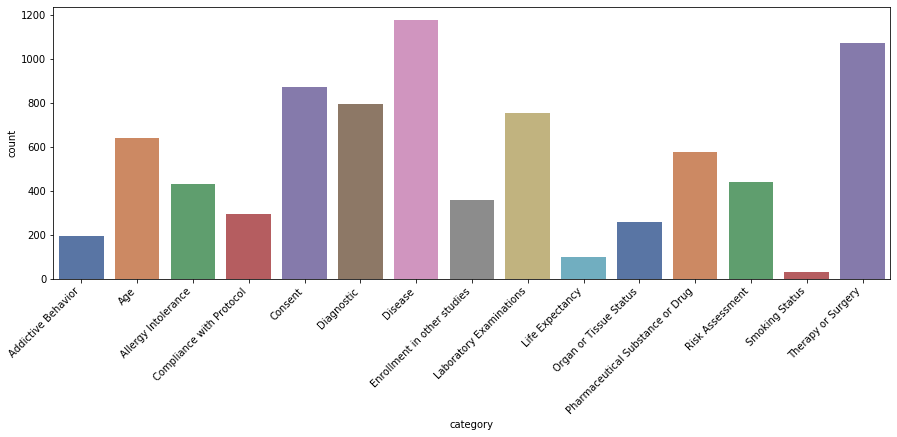

In [5]:
category_count = train_data.groupby(['category'],  as_index=False)['category'].agg({'count': 'count'})
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.barplot(x=category_count["category"], y=category_count["count"], palette="deep", ax=ax)
_ = ax.set_xticklabels(labels=category_count["category"], rotation=45, ha='right')
print(category_count)

### 载入测试数据

In [6]:
test_file = "../../data/test.txt" 
test_data = pd.read_csv(test_file, sep="\t", header=None, names=["id", "sentence"])

In [7]:
print("测试集数据有：{}条".format(len(test_data)))
print("前5条数据为：")
test_data.head(5)

测试集数据有：2000条
前5条数据为：


,id,sentence
0,s1,1.符合脓毒症诊断Sepsis 3.0版标准；
1,s2,1）符合WHO对不孕症的诊断标准；
2,s3,3. 肿瘤直径 ≥8mm且≤30mm;
3,s4,8.合并其他运动可能加重的神经、肌肉、骨骼肌、风湿性疾病；
4,s5,2. 符合国际疾病分类（ICD-10）编码 J21 的毛细支气管炎诊断标准。


## 特征构建

**tf-idf**（英语：term frequency–inverse document frequency）是一种用于信息检索与文本挖掘的常用加权技术。<br>
**tf-idf**是一种统计方法，用以评估一字词对于一个文件集或一个语料库中的其中一份文件的重要程度。字词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。<br>

在一份给定的文件里，**词频**（term frequency，tf）指的是某一个给定的词语在该文件中出现的频率。这个数字是对**词数**（term count）的归一化，以防止它偏向长的文件。（同一个词语在长文件里可能会比短文件有更高的词数，而不管该词语重要与否。）<br>

对于在某一特定文件里的词语$t_i$来说，它的重要性可表示为：<br>
$$ tf_{i,j} = {n_{i,j} \over \sum_{k} n_{k,j}}  \tag{1}$$

以上式子中$n_{i,j}$是该词在文件$d_j$中的出现次数，而分母则是在文件$d_j$中所有字词的出现次数之和。<br>

**逆向文件频率**（inverse document frequency，idf）是一个词语普遍重要性的度量。某一特定词语的idf，可以由总文件数目除以包含该词语之文件的数目，再将得到的商取以10为底的对数得到：<br>
$$idf_i = lg {|D| \over |\{j:t_i\in d_j\}+1|} \tag{2}$$

其中<br>
* $|D|$：语料库中的文件总数
* $|\{j:t_i\in d_j\}|$：包含词语的文件数目（即的文件数目）如果词语不在资料中，就导致分母为零，因此一般情况下使用$|\{j:t_i\in d_j\}+1|$

然后<br>
$$tf-idf_{i,j} = tf_{i,j} * idf_i  \tag{3}$$

某一特定文件内的高词语频率，以及该词语在整个文件集合中的低文件频率，可以产生出高权重的tf-idf。因此，tf-idf倾向于过滤掉常见的词语，保留重要的词语。

### 基于TF-IDF算法将文本转换为向量表示

In [8]:
def tfidf(sentences, max_features=500):
    # 使用jieba进行中文分词，并以空格隔开。
    preprocess_setences = []
    for sentence in sentences:
        words = [word for word in jieba.cut(sentence)]
        preprocess_setences.append(' '.join(words))

    # 根据词频选择词量，确定词向量维度
    vectorizer = CountVectorizer(max_features=max_features, binary='true')   # 将文本中的词语转换为词频矩阵
    word_counts = vectorizer.fit_transform(preprocess_setences) # 计算每个词语出现的次数
    pickle.dump(vectorizer.vocabulary_,open("NB_tfidf_feat.pkl","wb"))
    
    # 保存词语，词频
    with open("NB_tfidf_voca.txt", "w") as f:  
        for word, freq in vectorizer.vocabulary_.items():
            f.write("{}\t{}\n".format(word, freq))
    
    # 计算TF-IDF
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(word_counts)
    return list(tfidf.toarray())

将训练数据的文本表示为向量

In [9]:
train_text = train_data['sentence'].tolist()
result = tfidf(train_text, max_features=500)
train_X = [np.array(i) for i in result]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\310272~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.668 seconds.
Prefix dict has been built succesfully.


以词云显示筛选的构建词向量的词

(-0.5, 399.5, 199.5, -0.5)

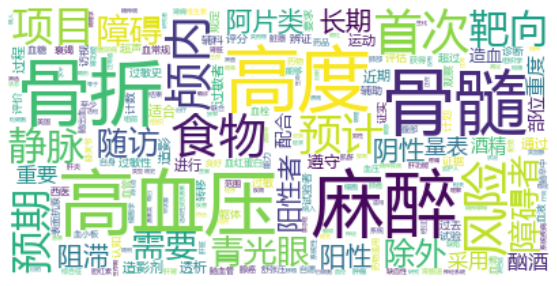

In [10]:
cloud_words = []
with open("NB_tfidf_voca.txt", "r") as f:
    for line in f:
        l = line.strip().split("\t")
        cloud_words.extend([l[0]] * int(l[1]))

wordcloud = WordCloud(background_color="white", collocations=False, max_words=1000, font_path="C:\\Windows\\Fonts\\msyh.ttc").generate(" ".join(cloud_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### 将类别转换为数字表示

将15个类别转换为数字0-14

In [11]:
categories = sorted(list(set(list(train_data['category']))))
category2tag = dict()
tag2category = dict()
for i, category in enumerate(categories):
    category2tag[category] = i
    tag2category[i] = category
    print("\x1b[32m{:>35}\x1b[0m >>>>>>>>>>>>>>>>>>>> \x1b[31m{:<2}\x1b[0m".format(category, i))

                 Addictive Behavior >>>>>>>>>>>>>>>>>>>> 0 
                                Age >>>>>>>>>>>>>>>>>>>> 1 
                Allergy Intolerance >>>>>>>>>>>>>>>>>>>> 2 
           Compliance with Protocol >>>>>>>>>>>>>>>>>>>> 3 
                            Consent >>>>>>>>>>>>>>>>>>>> 4 
                         Diagnostic >>>>>>>>>>>>>>>>>>>> 5 
                            Disease >>>>>>>>>>>>>>>>>>>> 6 
        Enrollment in other studies >>>>>>>>>>>>>>>>>>>> 7 
            Laboratory Examinations >>>>>>>>>>>>>>>>>>>> 8 
                    Life Expectancy >>>>>>>>>>>>>>>>>>>> 9 
             Organ or Tissue Status >>>>>>>>>>>>>>>>>>>> 10
   Pharmaceutical Substance or Drug >>>>>>>>>>>>>>>>>>>> 11
                    Risk Assessment >>>>>>>>>>>>>>>>>>>> 12
                     Smoking Status >>>>>>>>>>>>>>>>>>>> 13
                 Therapy or Surgery >>>>>>>>>>>>>>>>>>>> 14


将训练数据的类别标签全都转换为数字0-14

In [12]:
train_y = np.array([category2tag[c] for c in train_data['category']])
print(train_y)

[ 5 14  7 ...  4  4  1]


## 模型训练

### 模型训练

设置参数训练模型

In [13]:
start_time = time.time()
model = MultinomialNB()
model.fit(train_X, train_y)
print("training took {}s!".format(time.time() - start_time))

training took 0.044010162353515625s!


### 模型预测

输入一条句子进行预测

In [14]:
def predict(sentence):
    words = [word for word in jieba.cut(sentence)]
    sentence1 = ' '.join(words)

    vectorizer = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("NB_tfidf_feat.pkl", "rb")))
    sentence2 = vectorizer.transform([sentence1])
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(sentence2)
    sentence3 = tfidf.toarray()

    predicts = model.predict(sentence3)
    predict_category = tag2category[predicts[0]]
    return predict_category

In [15]:
for s in ["白细胞计数升高或大于10^9/L", "有糖尿病的患者", "术后发生非计划再次手术"]:
    print("\x1b[36m{:>35}\x1b[0m >>>>>>>>>>>>>>>>>>>> \x1b[35m{:<20}\x1b[0m".format(s, predict(s)))

                   白细胞计数升高或大于10^9/L >>>>>>>>>>>>>>>>>>>> Laboratory Examinations
                            有糖尿病的患者 >>>>>>>>>>>>>>>>>>>> Disease             
                        术后发生非计划再次手术 >>>>>>>>>>>>>>>>>>>> Therapy or Surgery  


### 模型保存

In [16]:
model_save_file = "NB_model.mkl"
pickle.dump(model, open(model_save_file, 'wb'))

## 模型评估

### 测试集预测

读取测试集的人工标注结果

In [17]:
test_true = list()
with codecs.open("../../data/test_gold.txt", "r", encoding="utf-8") as f:
    test_true = [line.strip().split("\t")[1] for line in f]

读取测试集，预测类别，并保存结果

In [18]:
test_pred = list()
test_sentences = list(test_data["sentence"])
n = 0
with codecs.open("NB_test_predict.txt", "w", encoding="utf-8") as f:
    for s in test_sentences:
        n += 1
        c = predict(s)
        test_pred.append(c)
        f.write("s{}\t{}\t{}\n".format(n,c,s))
        if n%100==0: 
            print("[processing]:{}/{}    ".format(n, len(test_sentences)))
            print("[precit]:\x1b[35m{:<40}\x1b[0m [true]:\x1b[32m{:<80}\x1b[0m".format(c, test_true[n-1]))
            print("[text]：\x1b[36m{:>0}\x1b[0m".format(s))

[processing]:100/2000    
[precit]:Laboratory Examinations                  [true]:Laboratory Examinations                                                         
[text]：c)白细胞计数升高或大于10^9/L
[processing]:200/2000    
[precit]:Disease                                  [true]:Disease                                                                         
[text]：2)目标眼有增殖性糖尿病视网膜病变（PDR）
[processing]:300/2000    
[precit]:Organ or Tissue Status                   [true]:Organ or Tissue Status                                                          
[text]：1. 凝血功能障碍；
[processing]:400/2000    
[precit]:Consent                                  [true]:Consent                                                                         
[text]：(5)同意参加本研究，同时符合以上标准者可纳入本研究。
[processing]:500/2000    
[precit]:Pharmaceutical Substance or Drug         [true]:Pharmaceutical Substance or Drug                                                
[text]：3）使用抗凝药（如华法令、低分子量肝素）和抗血小板聚集药物的患者；
[processing]:600/2000    
[pre

### 混淆矩阵

使用混淆矩阵展示预测结果

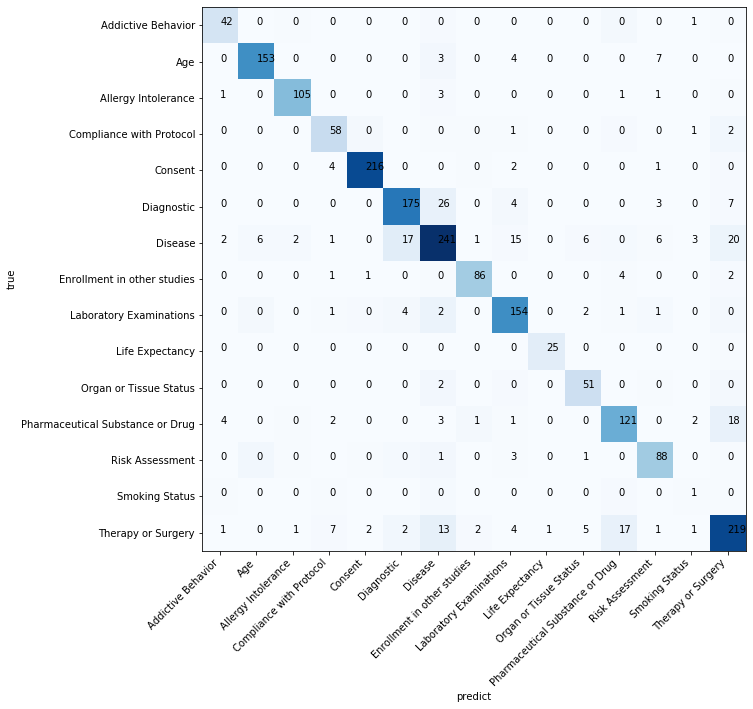

In [19]:
confusion = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10, 10))
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, categories, rotation=45, ha='right')
plt.yticks(indices, categories)
# plt.colorbar()
plt.xlabel('predict')
plt.ylabel('true')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

### 准确率、召回率、F1值

评价指标包括准确率，召回率和 $F1$ 值。并分别在宏平均和微平均两个水平上进行评估。<br>
假设有 $n$ 个类别： $C_1$, ..., $C_i$, ..., $C_n$, <br>
则各类别的准确率 $Precision_i$ 计算公式为<br>
$$Precision_i = {正确预测为C_i类的样本个数\over 预测为C_i类的样本个数} \tag{1}$$ <br>

各类别的召回率 $Recall_i$ 计算公式为<br>
$$Recall_i = {正确预测为C_i类的样本个数\over 真实的C_i类的样本个数} \tag{2}$$ <br>

宏平均准确率计算公式为<br>
$$宏平均准确率 = {1\over n}\sum_{i=1}^n Precision_i \tag{3}$$ <br>

宏平均召回率计算公式为<br>
$$宏平均召回率 = {1\over n}\sum_{i=1}^n Recall_i \tag{4}$$ <br>

宏平均 $F1$ 值计算公式为<br>
$$宏平均F1值 = {1\over n}\sum_{i=1}^n {2*Precision_i*Recall_i \over Precision_i+Recall_i} \tag{5}$$ <br>

In [20]:
results = evaluation.Record_results('../../data/test_gold.txt', 'NB_test_predict.txt')
evaluation = evaluation.Evaluation(results.records)

**************************************** Evaluation Results ****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.9767           0.8400           0.9032         
                                Age    0.9162           0.9623           0.9387         
                Allergy Intolerance    0.9459           0.9722           0.9589         
           Compliance with Protocol    0.9355           0.7838           0.8529         
                            Consent    0.9686           0.9863           0.9774         
                         Diagnostic    0.8140           0.8838           0.8475         
                            Disease    0.7531           0.8197           0.7850         
        Enrollment in other studies    0.9149           0.9556           0.9348         
            Laboratory Examinations    0.9333           0.8191           0.8725         
         